# imports

In [2]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np



In [3]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)


# Functions

## manage data functions

In [120]:
def repeat_single_value_in_column (df,value,column_name,to_print=False):
    if not isinstance(value, list) and not isinstance(value, np.ndarray):
        value = [value]

    # print(value)        
    if (len(value) != 1):
        if (to_print):
            print(f'value is not unique:{value}')
        return pd.DataFrame()
    
    df[column_name] = np.repeat(value,df.shape[0])
    return df

def get_vessel_data(vessel_data_dic,vessel_MMSI,to_print=False):
    if (1):
    # try:
        vessel_data = vessel_data_dic[vessel_MMSI]
        
        # repeat missing ID values
        ID_columns = ['IMO','Vessel_Name','Ship_Type']
        for ID_column in ID_columns:
            data = vessel_data[ID_column].loc[vessel_data[ID_column].notna()]
            data = data.unique()
            if (isinstance(data,str)):
                data = data.strip()
            # print(vessel_data.shape)
            vessel_data = repeat_single_value_in_column(vessel_data,data,ID_column)
            # print(vessel_data.shape)
            
            if (vessel_data.empty):
                if (to_print is True):
                    print(f'failed to create data base for vessel_MMSI={vessel_MMSI}')

                return vessel_data


        # take only the lines where there is a Longitude
        # print(vessel_data.shape)

        vessel_data = vessel_data[vessel_data['Longitude'].notna()]
        # print(vessel_data.shape)
 
        # sort data by time
        vessel_data = vessel_data.sort_values(by='Time')
        # print('sucess')
    # except:
    #     vessel_data = pd.DataFrame()
    #     # sys.exit(1)   
    return vessel_data




# vessel_MMSI = vessel_data_info['single'][100]
# vesel_data = get_vessel_data(vessel_data_dic,vessel_MMSI)

# vessel_data.head()


def get_vessel_data_stats(vessel_data):
    stats_dic = {
        'len': [vessel_data.shape[0]],  # Scalar value wrapped in a list
        'min_time':get_min_max_dates(vessel_data)[0],
        'max_time':get_min_max_dates(vessel_data)[1],
        'total_time':max(vessel_data['Time'])- min(vessel_data['Time']),
        'min_time_diff[mins]': round(np.min(time_diff_convert(vessel_data['Time'].diff()))),
        'max_time_diff[mins]': round(np.max(time_diff_convert(vessel_data['Time'].diff()))),
        'mean_time_diff[mins]': round(np.mean(time_diff_convert(vessel_data['Time'].diff()))),
        'min_Longitude':convert_to_float(min(vessel_data['Longitude'])),
        'max_Longitude':convert_to_float(max(vessel_data['Longitude'])),
        'min_Latitude':convert_to_float(min(vessel_data['Latitude'])),
        'max_Latitude':convert_to_float(max(vessel_data['Latitude'])),
    }
    stats_dic['diff_Longitude']  = stats_dic['max_Longitude']-stats_dic['min_Longitude']
    stats_dic['diff_Latitude']  = stats_dic['max_Latitude']-stats_dic['min_Latitude']

        # 'diff_Latitude':max(vessel_data['Latitude'])-min(vessel_data['Latitude'])


    return stats_dic






In [163]:
# def create_vessels_df(vessel_data_dic,MMSI_list,min_data_len_thresh = 2):
#     vessels_df = pd.DataFrame()
#     vessel_MMSI_prob = []

#     for i,vessel_MMSI in enumerate(MMSI_list):
#         if (i%1000==0):
#             print(f'proccessing MMSI {i} out of {len(vessel_data_info_list)}')
#         vessel_data = get_vessel_data(vessel_data_dic,vessel_MMSI)
#         if (vessel_data.shape[0]<min_data_len_thresh):
#             vessel_MMSI_prob.append(vessel_MMSI)
#         else:
#             vessels_df_line = pd.DataFrame(get_vessel_data_stats(vessel_data), index=[vessel_MMSI])  # Providing index explicitly
#             vessels_df = pd.concat([vessels_df,vessels_df_line])

#     vessels_df = vessels_df.sort_values(by='len',ascending=False)
#     print(vessels_df)
#     return vessles_df


In [190]:
import pandas as pd

def create_vessels_df(vessel_data_dic, MMSI_list, min_data_len_thresh=2,to_print = True):
    vessels_df = pd.DataFrame()
    vessel_MMSI_prob = []

    for i, vessel_MMSI in enumerate(MMSI_list):
        if (i % 1000 == 0):
            print(f'processing MMSI {i} out of {len(MMSI_list)}')
        vessel_data = get_vessel_data(vessel_data_dic, vessel_MMSI)  # Assuming get_vessel_data is defined elsewhere
        if (vessel_data.shape[0] < min_data_len_thresh):
            vessel_MMSI_prob.append(vessel_MMSI)
        else:
            vessels_df_line = pd.DataFrame(get_vessel_data_stats(vessel_data), index=[vessel_MMSI])
            vessels_df = pd.concat([vessels_df, vessels_df_line])

    vessels_df = vessels_df.sort_values(by='len', ascending=False)

    if (to_print):
        print (f"total number of MMSI:{len(MMSI_list)}")
        print (f"{vessels_df.shape[0]} MMSI's passed")
        print (f"{len(vessel_MMSI_prob)} MMSI's failed")



    return vessels_df,vessel_MMSI_prob  # Corrected return statement

# Example usage:
# vessels_df = create_vessels_df(vessel_data_dic, partial_list)


## File handling functions


In [64]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def save_vessel_data_to_geojson(vessel_data, file_path = './data', file_name=None):
    """
    Save latitude and longitude data from a DataFrame to a GeoJSON file.
    
    Parameters:
    - vessel_data: pandas DataFrame containing 'Latitude' and 'Longitude' columns.
    - file_path: Directory path where the GeoJSON file will be saved.
    - file_name: Name of the GeoJSON file (without the .geojson extension).
    """

    if (file_name is None):
        file_name = vessel_data['Vessel_Name'].iloc[0]

    file_name = file_name.rstrip()

    # Create a geometry column with Point objects
    geometry = [Point(lon, lat) for lon, lat in zip(vessel_data['Longitude'], vessel_data['Latitude'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(vessel_data, geometry=geometry, crs='EPSG:4326')  # Assuming WGS84 projection

    # Save to GeoJSON file
    file_name_geojson = f"{file_path}/{file_name}.geojson"
    gdf.to_file(file_name_geojson, driver='GeoJSON')


## Time functions

In [199]:
import pandas as pd

def filter_df_by_date(df, min_date, max_date, time_column='Time', date_format='%Y-%m-%d %H:%M:%S'):
    """
    Function to filter a DataFrame based on a time column and specified date range.
    
    Parameters:
    
    
    - df (pd.DataFrame): The input DataFrame.
    - min_date (str): The minimum date as a string.
    - max_date (str): The maximum date as a string.
    - time_column (str): The name of the column containing time data in the specified format.
    - date_format (str): The format of the date strings in the time column and min_date, max_date.
    
    Returns:
    - filtered_df (pd.DataFrame): The DataFrame filtered by the specified date range.
    """
    # Convert the Time column to datetime
    df[time_column] = pd.to_datetime(df[time_column], format=date_format)

    if (min_date is None):
        min_date = min(df[time_column])

    if (max_date is None):
        max_date = max(df[time_column])


    
    # Convert min_date and max_date to datetime
    min_date = pd.to_datetime(min_date, format=date_format)
    max_date = pd.to_datetime(max_date, format=date_format)
    
    # Filter the DataFrame based on the date range
    filtered_df = df[(df[time_column] >= min_date) & (df[time_column] <= max_date)]
    
    return filtered_df


# Define the minimum and maximum dates
# min_date = '2023-02-01 00:00:01'
# max_date = '2023-02-02 00:00:01'

# # Filter the DataFrame based on the date range
# df = filter_df_by_date(df, min_date, max_date)

# get_min_max_dates(df)



def time_diff_convert(time_diff,units='mins',to_round=True):
    if (not isinstance(time_diff,pd.core.series.Series)):
        is_series = False
        time_diff = pd.Series(time_diff)
    else:
        is_series = True

    if (units == 'secs'):        
        time_diff_mod = time_diff.apply(lambda x: x.total_seconds()) 
    
    if (units == 'mins'):        
        time_diff_mod = time_diff.apply(lambda x: x.total_seconds() / 60) 

    if (units == 'hours'):        
        time_diff_mod = time_diff.apply(lambda x: x.total_seconds() / 3600) 

    if (to_round):
        time_diff_mod = round(time_diff_mod)

    if (not is_series):
        time_diff_mod = time_diff_mod.values[0]        
    return time_diff_mod
    


    
def convert_time_format(df, time_column, current_format, output_format):
    """
    Function to convert the time format of a specified column in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - time_column (str): The name of the column containing time data.
    - current_format (str): The current format of the time data in the column.
    - output_format (str): The desired output format for the tim data.
    
    Returns:
    - df (pd.DataFrame): The DataFrame with the time column converted to the desired format.
    """
    # Convert the Time column to datetime using the current format
    df[time_column] = pd.to_datetime(df[time_column], format=current_format)
    
    # Convert the datetime to the desired output format
    df[time_column] = df[time_column].dt.strftime(output_format)
    
    return df




def get_min_max_dates(df, time_column='Time',input_format = '%Y-%m-%d %H:%M:%S',output_format='%Y-%m-%d %H:%M:%S'):
    """
    Function to get the minimum and maximum dates from a DataFrame's time column.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - time_column (str): The name of the column containing time data in '%Y-%m-%d %H:%M:%S' format.
    - output_format (str): The desired output datetime format.
    
    Returns:
    - min_date (str): The minimum date in the desired format.
    - max_date (str): The maximum date in the desired format.
    """
    # Convert the Time column to datetime
    df[time_column] = pd.to_datetime(df[time_column], format=input_format)
    
    # Get the minimum and maximum dates
    min_date = df[time_column].min().strftime(output_format)
    max_date = df[time_column].max().strftime(output_format)
    
    return min_date, max_date



# # Get the minimum and maximum dates in the desired format
# min_date, max_date = get_min_max_dates(df)

# print("Min date:", min_date)
# print("Max date:", max_date)


## Plot Functions

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
def plot_df_column_vs_time(df,column_name,time_column_name='Time'):

    # Sample data
    dates = df[time_column_name].dt.strftime('%Y-%m-%d %H:%M:%S').to_list()
    values = df[column_name]

    # Create a figure with a larger size
    plt.figure(figsize=(7, 4))

    # Create a line plot
    plt.plot(dates, values)

    # Rotate x-tick labels by 45 degrees and change their font size
    plt.xticks(rotation=45, fontsize=12, ha='right')


    # Use MaxNLocator to reduce the number of ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust the number of bins as needed

    # Add labels and title
    plt.xlabel('Date and Time')
    plt.ylabel('Values')
    plt.title('Plot with Rotated and Formatted x-tick Labels')

    # Add grid
    plt.grid(True)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Optionally adjust the subplots manually
    plt.subplots_adjust(bottom=0.2)

    # Show the plot
    plt.show()



## data converters

In [ ]:
def convert_to_float(s):
    """
    Convert a string representation of a number in exponential format to a float.
    
    Parameters:
    - s: String containing the number in exponential format.
    
    Returns:
    - Float representation of the number.
    """
    try:
        # Check if the string contains a decimal point in the exponent part
        if 'E+' in s or 'E-' in s or 'e+' in s or 'e-' in s:
            parts = s.split('E') if 'E' in s else s.split('e')
            
            # Extract the base number and exponent
            base = float(parts[0])
            exponent = float(parts[1])
            
            # Adjust exponent if it contains a decimal point
            if '.' in parts[1]:
                exponent = int(float(parts[1]))  # Convert to int to remove decimal part
            
            # Calculate the final float value
            result = base * (10 ** exponent)
            
            return result
        
        # If no 'E' or 'e' found, convert directly to float
        return float(s)
    
    except ValueError as e:
        print(f"Error converting '{s}' to float: {e}")
        return None




Original: '3E+1', Converted float: 30.0
Original: '2.2222E-3', Converted float: 0.0022222
Original: '3E+1.0', Converted float: 30.0


# Read the file

In [7]:
# Read the file
import pandas as pd
file_path = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\TipandCue_DataSample_CSV\\'
file_name = 'exactEarth_historical_data_02_2023.csv'
file_name_full = file_path+file_name

df_org = pd.read_csv(file_name_full,low_memory=False)

# Convert the Time column from 'YYYYMMDD_HHMMSS' to 'YYYY-MM-DD HH:MM:SS'
df_org = convert_time_format(df_org, 'Time', '%Y%m%d_%H%M%S', '%Y-%m-%d %H:%M:%S')



# get a filtered version of the df

In [200]:
df = copy.deepcopy(df_org)
df_org.info()


# Define the minimum and maximum dates
# min_date = '2023-02-01 00:00:01'
# max_date = '2023-02-02 00:00:01'

min_date = None
max_date = None

# Filter the DataFrame based on the date range
df = filter_df_by_date(df, min_date, max_date)

# get a list of interesing columns
columns_list = ['Time','MMSI','IMO','Vessel_Name','Ship_Type','Longitude','Latitude','Message_ID']
df = df[columns_list]
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772085 entries, 0 to 4772084
Columns: 139 entries, MMSI to spare4
dtypes: float64(121), int64(5), object(13)
memory usage: 4.9+ GB


,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
0,2023-02-04 14:19:27,377439000,NaN,NaN,NaN,53.7579433333,24.7750816667,1
1,2023-02-02 08:59:00,352724000,NaN,NaN,NaN,34.81821,29.21448,1
2,2023-02-07 12:51:57,563133800,NaN,NaN,NaN,55.049045,25.0228666667,3
3,2023-02-06 22:39:03,613460104,NaN,NaN,NaN,34.6435933333,36.7577,1
4,2023-02-06 06:56:42,341287000,NaN,NaN,NaN,55.2776883333,25.449845,3


## Export to exell

In [9]:
# df.shape
# df.loc[:, 'index'] = df.index
# columns = ['index'] + [col for col in df.columns if col != 'index']
# df = df[columns]
# df.head()
# df.to_excel('output.xlsx', index=False)


# Dividing the df by MMSI

In [201]:
grouped = df.groupby('MMSI')

# Create a dictionary to store each vessel's data
vessel_data_dic = {vessel_MMSI: group for vessel_MMSI, group in grouped}

# Print the keys of the dictionary (MMSI values)
print(vessel_data_dic.keys())

# Access the data for a specific vessel by its MMSI
# Replace '123456789' with an actual MMSI value from your data
MMSI = 500174
vessel_data_dic[MMSI]


dict_keys([0, 135, 422, 470, 23455, 420393, 500174, 1193046, 2129910, 2129930, 2129940, 2343242, 2576659, 2579999, 2717200, 2717201, 2717202, 2717215, 2717216, 2717218, 2717225, 2717226, 2717260, 2717263, 2717266, 4030945, 4030946, 4031006, 4031009, 4032010, 4033000, 4033001, 4033002, 4033003, 4033004, 4033005, 4082001, 4220407, 4221014, 4224100, 4224200, 4225203, 4225331, 4225399, 4280001, 4282000, 4381234, 4610003, 4661001, 5628343, 6221003, 6221005, 6221120, 6530000, 8821711, 9080716, 9123002, 9124120, 9124269, 9124811, 9125070, 9125082, 9125677, 9126842, 9126858, 9126866, 9126872, 9127182, 9129852, 9719996, 9719997, 9719999, 12345678, 41998001, 85687057, 103981995, 108080056, 108090115, 109012122, 109120254, 111111111, 118170269, 118315001, 123450000, 123456789, 136335526, 152487965, 152487966, 152487967, 152487968, 152487969, 161561880, 200000000, 200000002, 200008824, 201000000, 201892015, 203244573, 205135000, 205221570, 205231000, 205301810, 205373000, 205481000, 205506000, 205

,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
13540,2023-02-04 00:26:42,500174,NaN,NaN,NaN,NaN,NaN,8
23939,2023-02-02 14:42:28,500174,NaN,MAJED,NaN,NaN,NaN,24
33788,2023-02-01 10:28:16,500174,NaN,NaN,NaN,55.0836016667,25.5407266667,18
37383,2023-02-02 10:57:56,500174,NaN,NaN,NaN,NaN,NaN,8
49366,2023-02-03 07:23:09,500174,NaN,NaN,NaN,54.9412033333,25.4917216667,18
...,...,...,...,...,...,...,...,...
4715167,2023-02-06 13:38:15,500174,NaN,NaN,NaN,54.8862333333,25.4886416667,18
4727720,2023-02-06 18:35:39,500174,NaN,NaN,NaN,NaN,NaN,8
4732724,2023-02-03 12:49:18,500174,NaN,NaN,NaN,55.0741933333,25.5397483333,18
4754553,2023-02-07 12:07:45,500174,NaN,NaN,NaN,NaN,NaN,8


In [202]:
# def get_IMO_from_MMSI(MMSI,vessel_data_dic):
# for MMSI in (vessel_data_dic.keys()):
vessel_data_info = {'Nan':[],'single':[],'multiple':[]}
for i, MMSI in enumerate(vessel_data_dic.keys()):
    if (vessel_data_dic[MMSI]['IMO'][vessel_data_dic[MMSI]['IMO'].notna()].unique().shape[0] == 0):
        vessel_data_info['Nan'].append(MMSI)
    elif (vessel_data_dic[MMSI]['IMO'][vessel_data_dic[MMSI]['IMO'].notna()].unique().shape[0] == 1):
        vessel_data_info['single'].append(MMSI)
    elif (vessel_data_dic[MMSI]['IMO'][vessel_data_dic[MMSI]['IMO'].notna()].unique().shape[0] > 1):
        vessel_data_info['multiple'].append(MMSI)

print('Nan:'+ str(len(vessel_data_info['Nan'])))
print('single:'+ str(len(vessel_data_info['single'])))
print('multiple:'+ str(len(vessel_data_info['multiple'])))

MMSI_list = list(vessel_data_dic.keys())


Nan:3990
single:5421
multiple:44


# create the vessels_df

In [203]:
vessels_df,vessel_MMSI_prob = create_vessels_df(vessel_data_dic,MMSI_list)

processing MMSI 0 out of 9455
processing MMSI 1000 out of 9455
processing MMSI 2000 out of 9455
processing MMSI 3000 out of 9455
processing MMSI 4000 out of 9455
processing MMSI 5000 out of 9455
processing MMSI 6000 out of 9455
processing MMSI 7000 out of 9455
processing MMSI 8000 out of 9455
processing MMSI 9000 out of 9455
total number of MMSI:9455
5318 MMSI's passed
4137 MMSI's failed


## debug a single MMSI

In [204]:
MMSI = 341021000

In [205]:
vessel_data = get_vessel_data(vessel_data_dic,MMSI)
vessel_data

,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
2857372,2023-02-01 00:04:05,341021000,9083201.0,SANDAL,70.0,35.0289816667,32.824405,3
4438419,2023-02-01 00:16:06,341021000,9083201.0,SANDAL,70.0,35.028975,32.8244016667,3
4235386,2023-02-01 00:28:05,341021000,9083201.0,SANDAL,70.0,35.028955,32.8244116667,3
473806,2023-02-01 00:40:06,341021000,9083201.0,SANDAL,70.0,35.0289933333,32.8243933333,3
3770620,2023-02-01 00:52:07,341021000,9083201.0,SANDAL,70.0,35.0289783333,32.8244016667,3
...,...,...,...,...,...,...,...,...
2754481,2023-02-07 23:03:23,341021000,9083201.0,SANDAL,70.0,36.1526366667,36.6013266667,3
989634,2023-02-07 23:15:23,341021000,9083201.0,SANDAL,70.0,36.1526216667,36.6013266667,3
665227,2023-02-07 23:27:24,341021000,9083201.0,SANDAL,70.0,36.152615,36.6013516667,3
708894,2023-02-07 23:39:24,341021000,9083201.0,SANDAL,70.0,36.1526783333,36.6013766667,3


In [206]:
vessel_data = vessel_data_dic[MMSI]
vessel_data
# ID_column = 'IMO'
# data = vessel_data[ID_column].loc[vessel_data[ID_column].notna()]
# print(data)
# data = data.unique()
# print(data)
# if (isinstance(data,str)):
#     data = data.strip()
# print(vessel_data.shape)
# vessel_data = repeat_single_value_in_column(vessel_data,data,ID_column)
# data


,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
6067,2023-02-05 10:53:56,341021000,9083201.0,SANDAL,70.0,NaN,NaN,5
10298,2023-02-04 09:11:28,341021000,9083201.0,SANDAL,70.0,36.1527633333,36.6023833333,3
11686,2023-02-02 22:20:01,341021000,9083201.0,SANDAL,70.0,NaN,NaN,5
18200,2023-02-01 17:29:07,341021000,9083201.0,SANDAL,70.0,NaN,NaN,5
21572,2023-02-05 16:07:23,341021000,9083201.0,SANDAL,70.0,36.15147,36.60344,3
...,...,...,...,...,...,...,...,...
4762595,2023-02-02 15:10:06,341021000,9083201.0,SANDAL,70.0,35.0289883333,32.82441,3
4763446,2023-02-07 11:06:55,341021000,9083201.0,SANDAL,70.0,NaN,NaN,5
4767043,2023-02-05 05:14:27,341021000,9083201.0,SANDAL,70.0,36.1514933333,36.6035966667,3
4767111,2023-02-01 00:58:57,341021000,9083201.0,SANDAL,70.0,NaN,NaN,5


# plots of vessel data

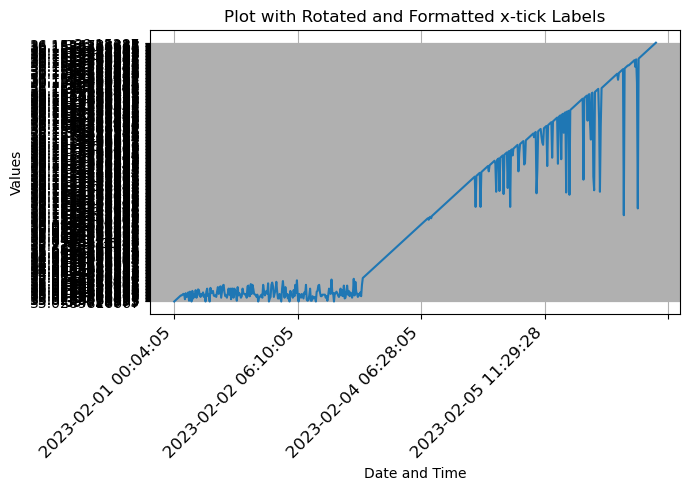

In [207]:
vessel_data = get_vessel_data(vessel_data_dic,MMSI) 

# vessel_data['Longitude'].plot(figsize=(10, 6), marker='o')

# vessel_data['Time'] = pd.to_datetime(vessel_data['Time'])

# vessel_data = vessel_data.sort_values(by='Time',ascending=True)
# print(vessel_data['Time'].iloc[0])
# print(vessel_data['Time'].iloc[vessel_data.shape[0]-1])
# plt.plot(vessel_data['Time'])
# print(type(vessel_data['Time']))

plot_df_column_vs_time(vessel_data,column_name='Longitude')


# Save the vessel_data to a jason file

 

In [ ]:
grouped = df.groupby('MMSI')

# Create a dictionary to store each vessel's data
vessel_data_dic = {vessel_MMSI: group for vessel_MMSI, group in grouped}


In [208]:

save_vessel_data_to_geojson(vessel_data)


vessels_df.loc[341021000]

len                                     586
min_time                2023-02-01 00:04:05
max_time                2023-02-07 23:51:24
total_time                  6 days 23:47:19
min_time_diff[mins]                       0
max_time_diff[mins]                    1403
mean_time_diff[mins]                     17
min_Longitude                     34.382508
max_Longitude                     36.152905
min_Latitude                      32.823483
max_Latitude                       36.62226
diff_Longitude                     1.770397
diff_Latitude                      3.798777
Name: 341021000, dtype: object